In [1]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pickle
import pyreadr
import os

from data import pipeline

pd.set_option("display.precision", 2)

# Data preparation

In [2]:
# Load / Build dataset

X_train, Y_train, X_test, Y_test = pipeline.load("SVR") # load / buildAndSave / build
print(X_train.shape, Y_train.shape)

Loading SVR dataset
Done!
(1050578, 31) (1050578, 1)


In [3]:
# Reduce dataset

from sklearn.model_selection import train_test_split

def reduceRandomly(X, Y, new_size):
    # Shuffle the dataset
    X_init, X_shuffled, Y_init, Y_shuffled = train_test_split(X, Y, test_size= len(X)-1)
    
    # Insert the non-shuffled value at a random index
    index = np.random.randint(0, len(X_shuffled))
    X_shuffled = np.concatenate((X_shuffled[:index], X_init, X_shuffled[index:]))
    Y_shuffled = np.concatenate((Y_shuffled[:index], Y_init, Y_shuffled[index:]))
    
    # Reduce the size of X and Y
    X_shuffled_reduced = X_shuffled[:new_size]
    Y_shuffled_reduced = Y_shuffled[:new_size]
    return X_shuffled_reduced, Y_shuffled_reduced

X_train, Y_train = reduceRandomly(X_train, Y_train, 20000)

In [4]:
# Normalisation

from sklearn.preprocessing import StandardScaler

Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
Y_train = sc_y.fit_transform(Y_train)
Y_train = Y_train.reshape(-1)

print(X_train.shape, Y_train.shape)

(20000, 31) (20000,)


# Training

In [5]:
# Import libraries for training and tuning

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import scipy.stats as stats

# Define the model

regressor = SVR(kernel= 'rbf',
                verbose= 1)

In [6]:
rand_list = {"C": stats.expon(scale=100)}

tuner = RandomizedSearchCV(
    estimator= regressor,
    param_distributions= rand_list,
    n_iter= 20,
    cv= 5,
    random_state= 0,
    n_jobs= -1,
    verbose= 1)

In [7]:
# Reload tuner
with open("svr_automl.pkl", "rb") as f:
    tuner = pickle.load(f)

#tuner.fit(X_train, Y_train)
#tuner.cv_results_

with open("svr_automl.pkl", "wb") as f:
    pickle.dump(tuner, f)

In [8]:
# Reload the model from the tuner

with open("svr_automl.pkl", "rb") as f:
    tuner = pickle.load(f)

regressor.set_params(**tuner.best_params_)

SVR(C=125.59307629658379, verbose=1)

In [ ]:
# Train the model

regressor.fit(X_train, Y_train)

In [17]:
# Compute the loss

from sklearn.metrics import mean_squared_error
from math import sqrt

print('Loss (RMSE) : %.3f' % sqrt(mean_squared_error(Y_train, regressor.predict(X_train))))

Loss (RMSE) : 0.227


# Evaluation

In [11]:
# Reduce the size of the test dataset

X_test = X_test[:999]
Y_test = Y_test[:999]
print(X_test.shape, Y_test.shape)

(999, 31) (999, 1)


In [12]:
decades_per_year = 37
Y_naive = [Y_test[4:4+decades_per_year].mean()]*3
for decade in range(3, len(Y_test), decades_per_year):
    growth_avg = Y_train[decade:decade + decades_per_year].mean()
    Y_naive += [growth_avg] * decades_per_year

print('Test RMSE with naive model : %.3f' % sqrt(mean_squared_error(Y_test, Y_naive[3:])))

Test RMSE with naive model : 42.801


In [13]:
Y_preds = regressor.predict(X_test)

print('Test RMSE : %.3f' % sqrt(mean_squared_error(Y_test, Y_preds)))

Test RMSE : 42.227


In [14]:
Y_preds = sc_y.inverse_transform(Y_preds.reshape(-1, 1))
Y_preds = Y_preds.reshape(-1)
Y_test = Y_test.reshape(-1)

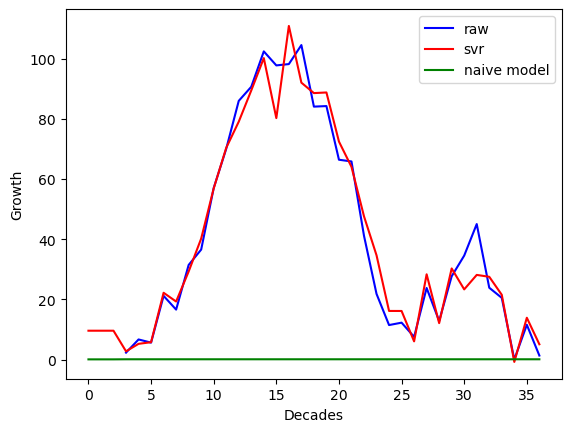

In [15]:
year = 5
decades = [decade for decade in range(37)]
plt.plot(decades, [None]*3 + list(Y_test[37*year:37*(year+1)-3]), color="blue", label= "raw")
plt.plot(decades, [9.57]*3 + list(Y_preds[37*year:37*(year+1)-3]), color="red", label= "svr")
plt.plot(decades, Y_naive[37*year:37*(year+1)], color="green", label= "naive model")
plt.xlabel("Decades")
plt.ylabel("Growth")
plt.legend()
plt.show()